In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
# from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval
import ast

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/manuscript_figs/"


In [3]:
ll=100 # QPC size
data_route = "../../data/exact_diag_new/L={}/".format(ll)
J=1


# Generate analysis Dataframe and save it
the reason I create a new dataframe instead of loading it is becasue its a pain to load 2d arrays this way and its just easier to generate them

In [4]:
file_list = get_file_names_on([], data_route)

['exact_L100_J1.0_t0.001_om0.3_Del7.0_xo30_k0.4712_bindex50_maxtau90.000_tstep0.180_alpha1.000_beta0.000_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t0.0001_om0.6_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.854_beta0.146_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t5.0_om1.0_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.163_beta0.837_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t2.0_om0.3_Del7.0_xo30_k1.3352_bindex50_maxtau90.000_tstep0.180_alpha0.354_beta0.646_phi0.0_alpha_bond1.571_qinitfixed.h5',
 'exact_L100_J1.0_t0.5_om0.1_Del7.0_xo30_k0.7854_bindex50_maxtau90.000_tstep0.180_alpha0.852_beta0.148_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.4_om0.1_Del7.0_xo30_k1.5708_bindex50_maxtau90.000_tstep0.180_alpha0.427_beta0.573_phi0.0_alpha_bond0.000_qinitfixed.h5',
 'exact_L100_J1.0_t0.4_om0.6_Del7.0_xo30_k1.4137_bindex50_maxtau90.000_tstep0.180_alpha0.985_beta0.015_phi0.0_alpha_bond1.571_qinitfixed.h5',
 

In [5]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    costheta_list, sinphi_list = get_bloch_angles_time(qubit_rho)

    # save raw data 
    data_dict["times"].append(times.astype(np.float32))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append((entropy/np.log(2)).astype(np.float32))
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(costheta_list)
    data_dict["sin_phi"].append(sinphi_list)

data_df = pd.DataFrame.from_dict(data_dict)

# data_df.to_csv("../../data/exp_pro/exact_diag_L={}.csv".format(ll))

In [6]:
# If we would like to load it anyways
"""data_df = pd.read_csv('../../data/exp_pro/exact_diag_L={}.csv'.format(ll))

data_df = data_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()
data_df["times"] = data_df["times"].apply(lambda x: [float(i) for i in ast.literal_eval(x)])
data_df["entropy"] = data_df["entropy"].apply(lambda x: [float(i) for i in ast.literal_eval(x)])"""

print("Number of data points:", len(data_df))
print(data_df.columns)
# read as float


Number of data points: 4048
Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi'],
      dtype='object')


Defining the parameters

In [7]:
Om_ = 0.3 # interaction strenght
X0_ = 30  # initial position

print("Values we are looking at")
af = data_df["alfabond"].sort_values().unique()[2]
print(np.cos(af/2)**2)
data_df["alfabond"].sort_values().unique()
data_df["X0"].unique()

Values we are looking at
0.8535533905932737


array([30])

# Entropy Phase Diagram and Spectrum

In [8]:
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')
S_df

t,0.0001,0.0010,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,...,0.3000,0.4000,0.5000,0.7000,0.8000,0.9000,1.0000,2.0000,3.0000,5.0000
K0,,,,,,,,,,,,,,,,,,,,,
0.471239,0.309272,0.313448,0.358923,0.397346,0.415030,0.420994,0.421851,0.419125,0.414626,0.408047,...,0.171824,0.158083,0.147135,0.124902,0.121770,0.110621,0.104378,0.006880,0.001878,0.000662
0.628319,0.233867,0.235436,0.252477,0.271226,0.286672,0.297947,0.305649,0.310815,0.314348,0.316801,...,0.152630,0.125774,0.115973,0.101219,0.095341,0.089756,0.084894,0.006191,0.001811,0.000657
0.785398,0.185104,0.185808,0.193358,0.202168,0.210569,0.217972,0.224129,0.229086,0.233077,0.236418,...,0.209323,0.128582,0.096317,0.084120,0.079781,0.075964,0.072591,0.005838,0.001783,0.000650
0.942478,0.154008,0.154389,0.158408,0.163117,0.167798,0.172209,0.176179,0.179618,0.182514,0.184920,...,0.221081,0.186037,0.118629,0.073163,0.070060,0.067749,0.065987,0.005607,0.001904,0.000698
1.099557,0.134203,0.134445,0.136950,0.139846,0.142740,0.145525,0.148108,0.150426,0.152442,0.154144,...,0.175991,0.187637,0.174001,0.080741,0.066310,0.064982,0.065176,0.005033,0.001936,0.000770
1.178097,0.127307,0.127510,0.129597,0.131987,0.134368,0.136662,0.138802,0.140735,0.142429,0.143867,...,0.157609,0.168430,0.175879,0.103609,0.073226,0.066096,0.067480,0.005212,0.002056,0.000703
1.256637,0.121996,0.122172,0.123971,0.126012,0.128035,0.129981,0.131798,0.133444,0.134890,0.136120,...,0.143940,0.151515,0.162982,0.133923,0.093441,0.073527,0.072435,0.004905,0.001878,0.000771
1.335177,0.118058,0.118216,0.119821,0.121624,0.123402,0.125107,0.126696,0.128136,0.129401,0.130475,...,0.134193,0.139294,0.148069,0.154693,0.122719,0.092119,0.081768,0.005066,0.002078,0.000718
1.413717,0.115345,0.115491,0.116969,0.118620,0.120239,0.121785,0.123224,0.124526,0.125667,0.126633,...,0.127684,0.131183,0.137463,0.159418,0.149947,0.121112,0.096611,0.004876,0.001984,0.000783


In [656]:
def plot_verticals(ax, tvals, tmarkers, clists):
    vdf = data_S[data_S["t"]== tvals].sort_values(by="K0")
    k0_values = vdf["K0"].unique()
    
    for i in range(0,len(k0_values)):
        ki = k0_values[i]
        cond_df = vdf[vdf["K0"] == ki]
        x_vals = cond_df["times"].item()
        y_vals = cond_df["entropy"].item()
        ax.plot(x_vals, y_vals, color=clists[i], linewidth = 3.1)
    
        # plot marker at maximum entropy
        #idx = np.argmax(y_vals)
        idx = -10
        ax.scatter(x_vals[idx], y_vals[idx], s=85, edgecolor="black",color=clists[i], marker=tmarkers,zorder=7)
    
    ax.set_ylabel(r"$S(\tau)/\ln 2$")
    ax.set_xlabel(r"$\tau$",labelpad=-0.1)
    
    ax.set_ylim(-0.02,0.41)


def plot_horizontals(ax, kvals, kmarkers, clists):
    vdf = data_S[data_S["K0"]== kvals].sort_values(by="t")
    t_values = vdf["t"].unique()
    
    for i in range(0,len(t_values)):
        ti = t_values[i]
        cond_df = vdf[vdf["t"] == ti]
        x_vals = cond_df["times"].item()
        y_vals = cond_df["entropy"].item()
        ax.plot(x_vals, y_vals, color=clists[i], linewidth = 3.1)
    
        # plot marker at maximum entropy
        # idx = np.argmax(y_vals)
        idx = -10
        ax.scatter(x_vals[idx], y_vals[idx], s=85, edgecolor="black",color=clists[i], marker=kmarkers,zorder=7)
    
    ax.set_ylabel(r"$S/\ln{2}$")
    ax.set_xlabel(r"$\tau$")
    
    ax.set_ylim(-0.02,0.5)


In [696]:
def plot_maxS_vertical(ax, tvals_list, clists_list, marker_list): 
    
    for j in range(0, len(tvals_list)):
        tvals = tvals_list[j]
        clists = clists_list[j]
        vdf = data_S[data_S["t"]== tvals].sort_values(by="K0")
        m_ = marker_list[j]
        for i in range(0,len(K0_unique)):
            ki = K0_unique[i]
            yval = vdf[vdf["K0"]==ki]["Max_entropy"].item()
            ax.scatter(K0_unique[i], yval, c=[clists[i]], s=85, edgecolor='black', marker=m_)

    ax.axvline(0.4*np.pi/2, linestyle = "dotted", c="red", linewidth=3, zorder=0)
    
    ax.set_xlabel(r"$k_0/J$",labelpad=-0.1)
    ax.set_ylabel(r"$S_{\rm Max}/\ln{2}$")

def plot_maxS_horizontal(ax, kvals_list, clists_list, marker_list): 
    
    for j in range(0, len(kvals_list)):
        kvals = kvals_list[j]
        clists = clists_list[j]
        vdf = data_S[data_S["K0"]== kvals].sort_values(by="t")
        m_ = marker_list[j]
        t_unique = np.sort(data_S["t"].unique())
        for i in range(0,len(t_unique)):
            ti = t_unique[i]
            yval = vdf[vdf["t"]==ti]["Max_entropy"].item()
            ax.scatter(t_unique[i], yval, c=[clists[i]], s=85, edgecolor='black', marker=m_)

    ax.axvline(np.pi/(ll+1), linestyle = "dashed", c="red", linewidth=3, zorder=0)
    ax.axvline(J, linestyle = "dashed", c="red", linewidth=3, zorder=0)
    ax.set_xscale("log")
    
    ax.set_xlabel(r"$\omega/J$",labelpad=-0.1)
    ax.set_ylabel(r"$S_{\rm max}/\ln{2}$")



In [697]:
def plot_transmision(ax, k_list, t_, color_list): 
    for i in range(0,len(k_list)):
        ki = k_list[i]
        # for slow particles
        curr_df = data_S[data_S["K0"]== ki]
        bindex = curr_df[curr_df["t"]==t_]["bond_index"].item()
        occ_matrix = curr_df[curr_df["t"]==t_]["occupations"].item()
        bond_density1 = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
        transmission1 = np.sum(occ_matrix[bindex+2:,:], axis=0)

        ax.plot(bond_density1,c = color_list[i], linestyle="dashed",linewidth=3)
        ax.plot(transmission1, c = color_list[i],linewidth=3.5)
        
    ax.set_xlabel(r"$\tau$", labelpad=0.01)
    ax.set_ylabel(r"$|\psi_n|$")
    ax.set_ylim(-0.04,1)
    

In [710]:
def S_heatmap(ax, t1_, t2_, k01_, k02_):
    vg_array = S_df.index
    t_array = S_df.columns
    im = ax.contourf(t_array, vg_array, S_df.values,levels=10)
    
    # plot vertical cuts
    for ki in range(0,len(K0_unique)):
        ax.scatter(t1_, K0_unique[ki], s=110, edgecolor="black",color=colorsv1[ki], zorder=3)
        ax.scatter(t2_, K0_unique[ki], s=110, edgecolor="black",marker="v",color=colorsv2[ki], zorder=3)
        
    # plot horizontal cuts
    for ti in range(0,len(t_unique)):
        ax.scatter(t_unique[ti], k01_, s=150, edgecolor="black",marker="D", color=colors_h1[ti], zorder=3)
        ax.scatter(t_unique[ti],k02_, s=150, edgecolor="black",marker="s",color=colors_h2[ti], zorder=3)
    
    ax.set_xscale('log')
    
    # Add anotate the regions
    y_tick = np.pi/2 -0.04
    ax.annotate(
        r'$\omega=\rm{min}[ \Delta E(k)]$', 
        xy=(np.pi/(ll+1), y_tick), 
        xytext=(np.pi/(ll+1) - 0.01, y_tick + 0.06), fontsize=base_font,ha='center')
    ax.annotate(
        r'$\omega=J$', 
        xy=(J+0.01, y_tick), 
        xytext=(J, y_tick + 0.06), fontsize=base_font,ha='center')
    
    # Add the labels for each region
    """ax.annotate('II', xy=(0.1+np.pi/50, 0.65*np.pi/2), 
                xytext=(0.1+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')
    
    ax.annotate('III', xy=(0.005, 0.65*np.pi/2), 
                xytext=(0.005, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')
    
    ax.annotate('I', xy=(2.0, 0.65*np.pi/2), 
                xytext=(2.0, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')"""
    
    ax.axvline(np.pi/(ll+1), color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line
    ax.axvline(J,color='red', lw=4, linestyle="dashed", clip_on=False )

    ax.hlines([0.35*np.pi/2], xmin=0.0001, xmax=J, color='red', lw=4, linestyle="dotted", clip_on=False)  # tick-like line

    ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=base_font-1)
    ax.set_yticks( [0.20*np.pi,0.35*np.pi,0.50*np.pi], labels=[r"$0.20 \pi$",r"$0.35\pi$",r"$0.50\pi$"],fontsize=base_font-1)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.03)
    fig = ax.figure
    cbar = fig.colorbar(im, cax, shrink=0.9)   
    cbar.ax.set_ylabel(r'$S_{\rm max}/\ln{2}$', rotation=90, fontsize=base_font)
    
    ax.set_ylabel(r"$k_0/J$",fontweight='bold',fontsize=base_font)
    ax.set_xlabel(r"$\omega/J$",fontweight='bold',fontsize=base_font)



In [711]:
# colors
# For the vertical line cuts
K0_unique = np.sort(data_S["K0"].unique())

colorsv1 = plt.cm.Greens(np.linspace(0.3, 1.0,len(K0_unique)))
colorsv2 = plt.cm.Greens(np.linspace(0.3, 1.0,len(K0_unique)))

# For the horizontal line cuts
t_unique = np.sort(data_S["t"].unique())
colors_h1 = plt.cm.Purples(np.linspace(0.3,1.0,len(t_unique)))
colors_h2 = plt.cm.Purples(np.linspace(0.3,1.0,len(t_unique)))


### Option 1

In [712]:
tvals_list = [0.001, 0.2]
kvals_list = [K0_unique[1],K0_unique[-8]]
vlists_list = [colorsv1, colorsv2]
hlists_list = [colors_h1, colors_h2]
high_colors = ["black", "grey"]

vmarker_list = ["o", "v"]
hmarker_list = ["D", "s"]

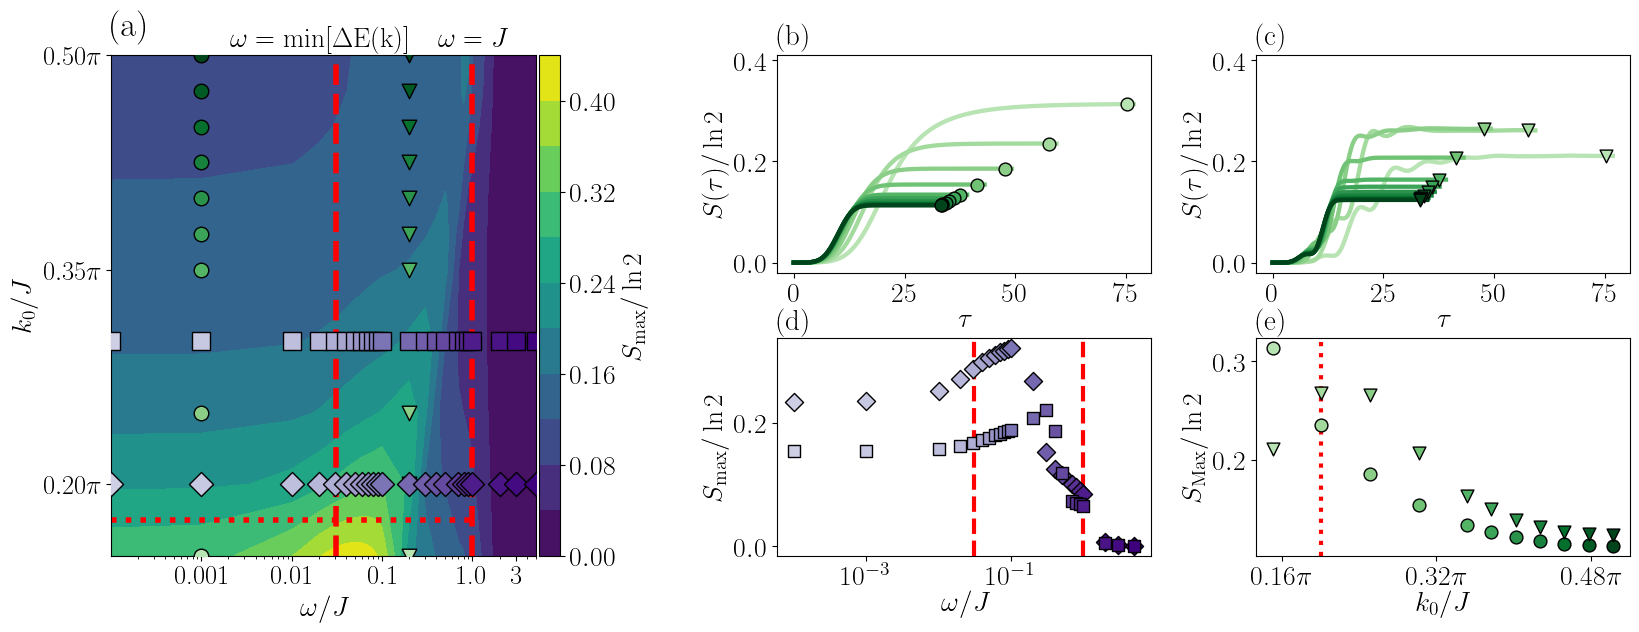

In [713]:

fig2 = plt.figure(figsize=(2.8*bwidth, 1.3*bheight))
gs = fig2.add_gridspec(2, 3,wspace=0.24, hspace=0.3,  width_ratios=[1.8, 1.2, 1.2])

axA = fig2.add_subplot(gs[:, 0]) # heatmap
axB = fig2.add_subplot(gs[0, 1])   
axC = fig2.add_subplot(gs[0, 2])  
axD = fig2.add_subplot(gs[1, 1]) 
axE = fig2.add_subplot(gs[1, 2])   

S_heatmap(axA, t1_=tvals_list[0], t2_=tvals_list[1], k01_= kvals_list[0] 
            ,k02_= kvals_list[1])

plot_verticals(axB, tvals_list[0], "o", colorsv1)
plot_verticals(axC, tvals_list[1], "v", colorsv2)
plot_maxS_horizontal(axD, kvals_list, hlists_list, hmarker_list)
plot_maxS_vertical(axE, tvals_list, vlists_list, vmarker_list)

# annotations for upper plots
axA.annotate(r"(a)", xy=[0.0,1.04], fontsize=25, xycoords="axes fraction")
axB.annotate(r"(b)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")
axC.annotate(r"(c)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")
axF.annotate(r"(f)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")

# annotations for lower plots
axD.annotate(r"(d)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")
axE.annotate(r"(e)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")
axG.annotate(r"(g)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")


# adjust padding on the colorbar
pos = axA.get_position()
axA.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
# put the x axis in units of pi # write x axis in units of pi
plt.subplot(gs[1, 2]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.2g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.savefig(fig_route+"entropy_phase_diagramV1.pdf",transparent=True)

### Option 2


fig2 = plt.figure(figsize=(3.1*bwidth, 1.3*bheight))
gs = fig2.add_gridspec(2, 4,wspace=0.23, hspace=0.3,  width_ratios=[2., 1, 1, 1])

axA = fig2.add_subplot(gs[:, 0]) # heatmap
axB = fig2.add_subplot(gs[0, 1])  # vertical cut 1 
axC = fig2.add_subplot(gs[0, 2]) # vertical cut 2 
axD = fig2.add_subplot(gs[1, 1]) # horizontal cut 1 
axE = fig2.add_subplot(gs[1, 2]) # horizontal cut 2 
axF = fig2.add_subplot(gs[0, 3]) # Transmision Reg I
axG = fig2.add_subplot(gs[1, 3]) # Transmision Reg II


S_heatmap(axA, t1_=tvals_list[0], t2_=tvals_list[1], k01_= kvals_list[0] 
            ,k02_= kvals_list[1])

plot_verticals(axB, tvals_list[0], "o", colorsv1)
plot_verticals(axC, tvals_list[1], "v", colorsv2)
plot_horizontals(axD, kvals_list[0], "D", colors_h1)
plot_horizontals(axE, kvals_list[1], "D", colors_h1)
plot_transmision(axF, kvals_list, 0.001, ["black", "grey"])
plot_transmision(axG, kvals_list, 0.2, ["black", "grey"])

# annotations for upper plots
axA.annotate(r"(a)", xy=[0.0,1.04], fontsize=25, xycoords="axes fraction")
axB.annotate(r"(b)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")
axC.annotate(r"(c)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")
axF.annotate(r"(f)", xy=[0.0,1.05], fontsize=21, xycoords="axes fraction")

# annotations for lower plots
axD.annotate(r"(d)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")
axE.annotate(r"(e)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")
axG.annotate(r"(g)", xy=[0.0,1.04], fontsize=21, xycoords="axes fraction")

# annotate the region in the transmission
axF.annotate(r"III", xy=[0.7,0.3], color="red", xycoords="axes fraction",fontsize= 50,fontweight='bold')
axG.annotate(r"II", xy=[0.7,0.3], color="red", xycoords="axes fraction",fontsize= 50,fontweight='bold')

pos = axA.get_position()
axA.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])

plt.savefig(fig_route+"entropy_phase_diagramV2.pdf",transparent=True)

### Looking at the wavefunction directly

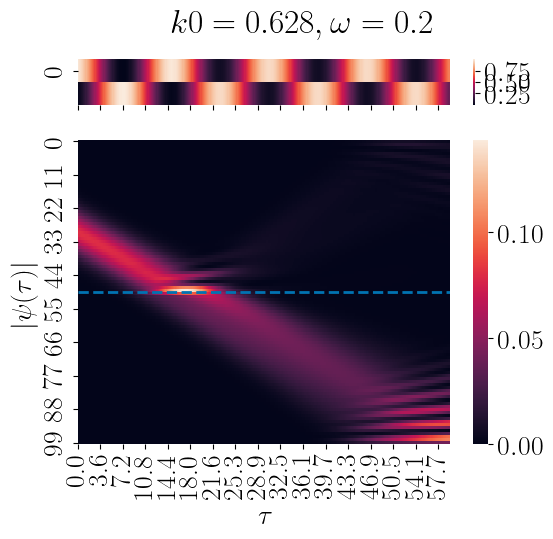

In [620]:
cond_ = (data_S["K0"] == kvals_list[0]) & (data_S["t"] == tvals_list[1]) 

curr_df = data_S[cond_]

fig, ax = plt.subplots(2,1,figsize=(bwidth-1,bheight), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})
plt.suptitle(r"$k0={:.3f}, \omega={}$".format( kvals_list[0], tvals_list[1]))
# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"$|\psi(\tau)|$")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


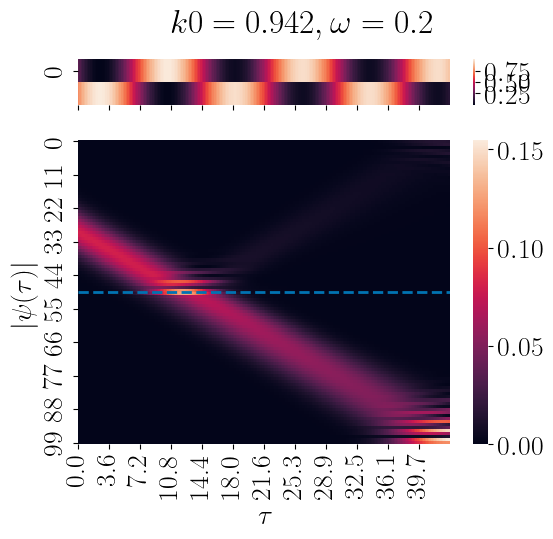

In [621]:
cond_ = (data_S["K0"] == kvals_list[1]) & (data_S["t"] == tvals_list[1]) 

curr_df = data_S[cond_]

fig, ax = plt.subplots(2,1,figsize=(bwidth-1,bheight), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})
plt.suptitle(r"$k0={:.3f}, \omega={}$".format( kvals_list[1], tvals_list[1]))
# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"$|\psi(\tau)|$")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);